<a id='toc'></a>

<div class="alert alert-block alert-info">
<center> <h1> Enterprise Data Science Bootcamp </h1> </center> <br>
<center> <h2> Inventory Management- Back Orders </h2> </center>
<center> <h3>   2021/2022 </h3> </center>

**GROUP E:** <br>
- Nuno Bolas          `20211052` <br>
- João Magalhães      `20211044` <br>
- Mariana Teixeira    `20211058` <br>
- Maria Trindade      `20211049` <br>

https://medium.com/analytics-vidhya/predicting-material-backorders-in-inventory-management-90e4d0ece6ba



## Table of Contents

* [Import](#chapter0)
* [Data Understanding](#chapter1)
* [Data preparation](#chapter2)
* [Feature Engineering](#chapter3)
* [Feature Selection](#chapter4)
* [Train Test Split](#chapter7)
* [Balancing the dataset](#chapter8)
* [Modelling](#chapter5)
    * [K-Folds and Repeated K-Folds](#chapter5.1) -
    * [Logistic Regression](#chapter5.2) -
    * [Neural Networks](#chapter5.3) -
    * [Random Forest](#chapter5.4)
    * [Gradient Boosted Decision Tree](#chapter5.5)
    * [Adaboost](#chapter5.6)
    * [Extra Trees](#chapter5.7)
    * [Balanced Bagging](#chapter5.8)

[Back to the start](#toc)

## Import <a class="anchor" id="chapter0"></a>

In [2]:
#Data Understanding
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer

#Feature Engineering/Selection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp
from scipy import stats

# Modelling 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
# Set the style for the Seaborn's plots
sns.set_style('whitegrid',{
    'xtick.bottom': False,
    'xtick.color': '.1',
    'xtick.direction': 'out',
    'xtick.top': False,
    'xtick.major.size': 1,
    'xtick.minor.size': 0.5,
    'ytick.left': True,
    'ytick.color': '.1',
    'ytick.direction': 'out',
    'ytick.right': False,
    'ytick.major.size': 1,
    'ytick.minor.size': 0.5,    
    'ytick.color': '.1',
    'grid.linestyle': '--',
    'axes.edgecolor': '.1',
    'grid.color': '0.8'
 })

palette = sns.color_palette("Set2") 
sns.set_palette(palette)

[Back to the start](#toc)

## Data Understanding <a class="anchor" id="chapter1"></a>

In [ ]:
test = pd.read_csv("data/Test_Dataset_v2.csv")
train = pd.read_csv("data/Training_Dataset_v2.csv")

In [ ]:
train['perf_6_month_avg'].mean()

In [ ]:
train['perf_12_month_avg'].mean()

In [ ]:
test.head(5)

### Initial Analysis

In [ ]:
#train = train.set_index("sku")
#test = test.set_index("sku")

In [ ]:
# descriptive statistics for the variables
train.describe()

In [ ]:
train.describe(include=['O'])

In [ ]:
train.info()

In [ ]:
# Duplicated records
print('Train: \n',train.duplicated().value_counts(),'\n') 

In [ ]:
# Missing Values on train dataset
train.isna().sum()

lead_time - Transit time for product (if available)

    Sku is the identifier and therefore, the index; 

    Out of the other 21 features (excluding the class label went_on_backorder), 15 of them are numerical and 6 of them are categorical. 
    All the categorical features (potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy and rev_stop) have either Yes or No, so we will transform them to binary; 

    The numerical features include national_inv, lead_time, in_transit_qty, forecast_3_month, forecast_6_month, forecast_9_month, sales_1_month, sales_3_month, sales_6_month, sales_9_month, min_bank, pieces_past_due, perf_6_month_avg, perf_12_month_avg, local_bo_qty. 

    lead_time is the only feature with missing values.In addition, the last row of every feature has null values so will removed. 

### Pandas profiling

In [ ]:
#pip install pandas-profiling

In [ ]:
#profile = ProfileReport(train)
#profile  

In [ ]:
#profile.to_file("report.html")

* The target variable went_on_backorder is a categorical feature with two values "Yes" and "No".
* 99.33% belong to the class "Yes" and remaining 0.669% belong to the class "No"; dataset is highly imbalanced with majority and minority class ratio of approximately 148:1
* in_transit_qty has 1344662 (79.7%) zeros

Real numbers: 
* forecasts: ~65% is 0; very correlated within themselves and with sales; highly skewed; with outliers;
* in transit: skewed; with ~80% of 0s; small IQR; many outliers; 
* lead_time: has 6% of missing values; 
* local_bo_qty: skewed; 98.9% of 0 values; 
* min_bank: 52% 0s; 
* performance features 6,12 months: high correlation with themselves, ~7-8% of -99
* pieces_past_due: skewed, 98.5% 0s; 
* sales: skewed; lots of 0s ~40%; high correlation with each others; 

Booleans: 
* oe_constraint: 99% no (high relation with backorder); 
* potential_issue: 99.9% No(high relation with backorder);
* ppap_risk: -
* rev_stop: 99.9% no (no relation with backorder). 

[Back to the start](#toc)

## Data Preparation <a class="anchor" id="chapter2"></a>

### Missing values

In [ ]:
#total = np.round(train['lead_time'].isna().sum()/ len(train), 4)
#print('Total percentage of Missing Values: ', total*100, '%')

In [ ]:
#train.drop(train[train['national_inv'].isna()].index,inplace = True) 
#This line was NA in all values but sku, so it was deleted

In [ ]:
#train_numerical = train.select_dtypes(include='number')

In [ ]:
#imputer = KNNImputer(n_neighbors=2, weights="uniform").fit(train_numerical)
#imputed_matrix = imputer.transform(train_numerical)

In [ ]:
#data_cleaned = pd.DataFrame(data=imputed_matrix, columns=train_numerical.columns, index=train_numerical.index)

In [ ]:
#train[data_cleaned.columns] = data_cleaned

In [ ]:
#train.isna().sum()

In [ ]:
#train.to_csv('train_knncleaned.csv')

In [200]:
train = pd.read_csv('train_knncleaned.csv')

In [209]:
train.set_index('sku',inplace = True)

### Duplicates

In [5]:
#train.duplicated().sum() 0 duplicates without index as sku

In [6]:
#train.duplicated().sum()/train.shape[0] 

There are no duplicates in this dataset

In [7]:
train = train.set_index("sku")

In [8]:
train.drop(columns = ['Unnamed: 0'],inplace = True)

In [9]:
train.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1026827,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
1043696,2.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
1044048,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


### Outliers

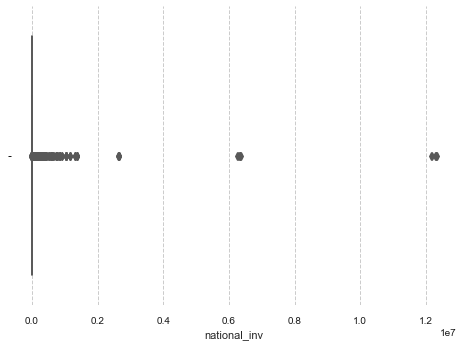

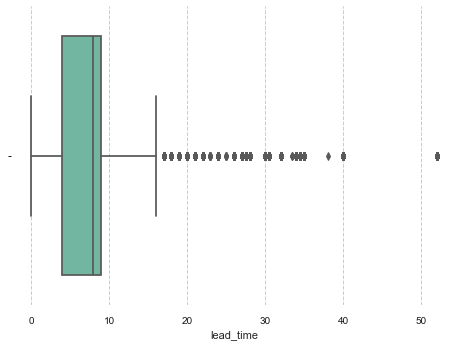

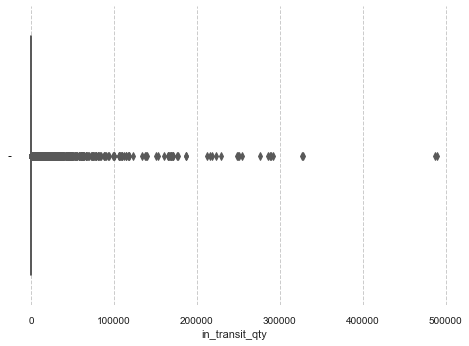

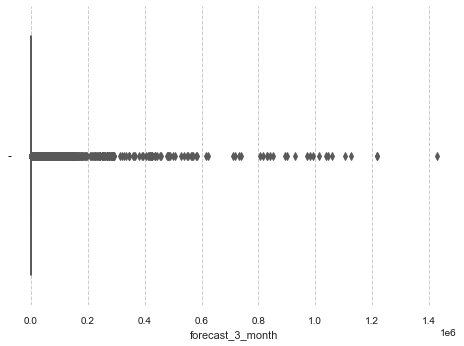

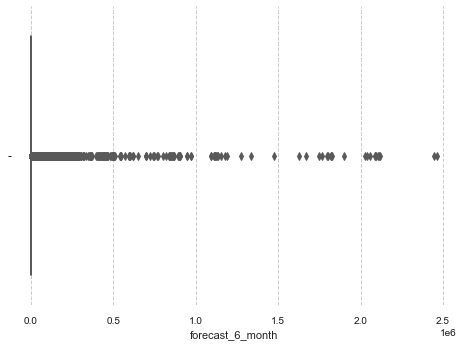

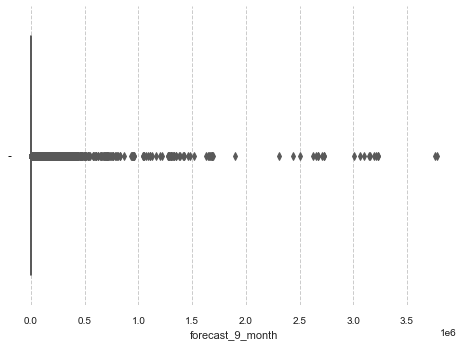

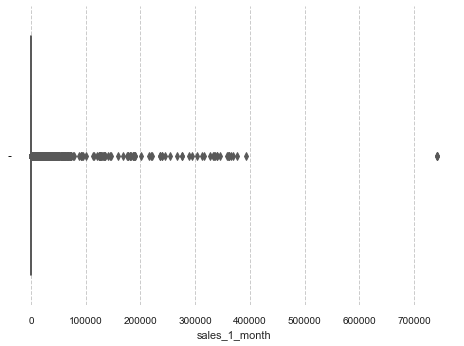

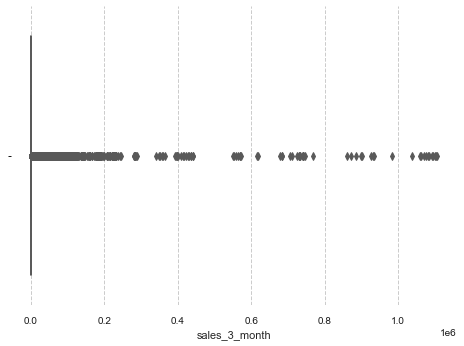

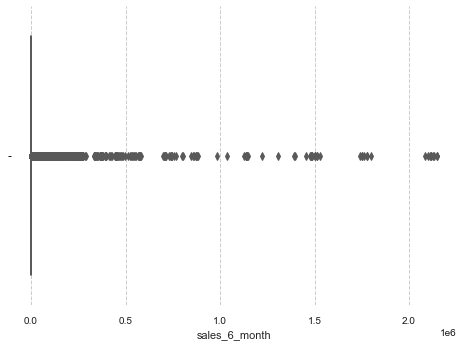

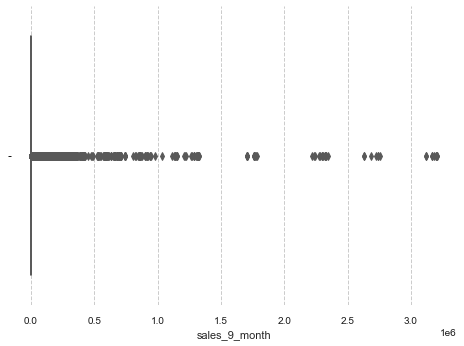

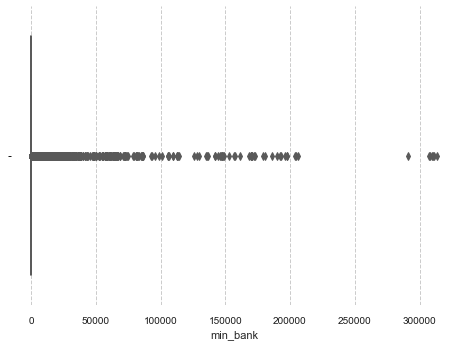

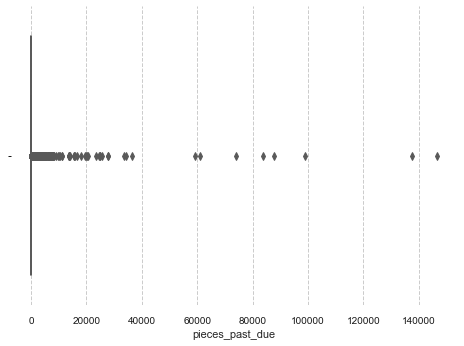

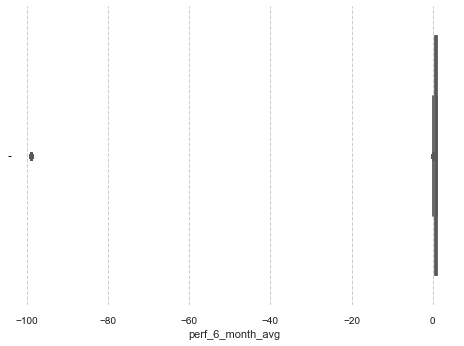

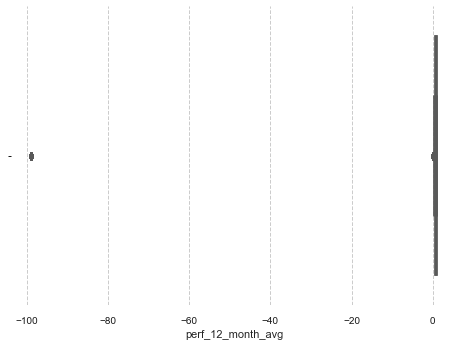

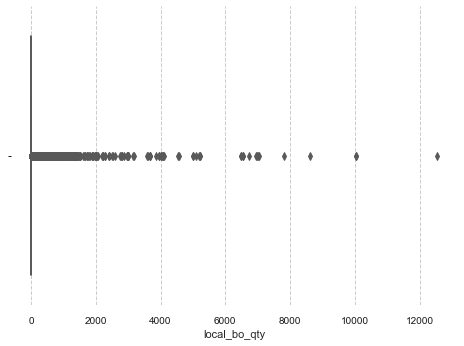

In [10]:
train_numerical = train.select_dtypes(include='number')

for i in train_numerical:
    sns.boxplot(data=train_numerical, x=i)
    plt.show()

In [11]:
outlier_metric_features = train_numerical.columns

#### Outliers

In [12]:
q25 = train.quantile(.25)
q75 = train.quantile(.75)
iqr = (q75 - q25)



upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr



filters2 = []
for metric in outlier_metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(train[metric].between(llim, ulim, inclusive=True))


filters2 = pd.Series(np.all(filters2, 0), index=train.index)
df_2 = train[filters2]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / train.shape[0], 4))

Percentage of data kept after removing outliers: 0.5295


/var/folders/89/gv90tkm505qglgm9s_mrxwxw0000gn/T/ipykernel_4680/3564339984.py:16: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  filters2.append(train[metric].between(llim, ulim, inclusive=True))


#### Z-score

In [13]:
total = 0
for i in outlier_metric_features: 
    z = np.abs(stats.zscore(train[i])) 
    z[z > 3].count()
    print('Percentage of outliers for',str(i),' : ', (np.round((z[z > 3].count())/ len(train), 4)*100))
    total += (np.round((z[z > 3].count())/ len(train), 4))

print('Total percentage of Outliers: ', total*100, '%')

Percentage of outliers for national_inv  :  0.04
Percentage of outliers for lead_time  :  2.6
Percentage of outliers for in_transit_qty  :  0.13999999999999999
Percentage of outliers for forecast_3_month  :  0.15
Percentage of outliers for forecast_6_month  :  0.15
Percentage of outliers for forecast_9_month  :  0.13999999999999999
Percentage of outliers for sales_1_month  :  0.1
Percentage of outliers for sales_3_month  :  0.12
Percentage of outliers for sales_6_month  :  0.13
Percentage of outliers for sales_9_month  :  0.12
Percentage of outliers for min_bank  :  0.15
Percentage of outliers for pieces_past_due  :  0.04
Percentage of outliers for perf_6_month_avg  :  7.670000000000001
Percentage of outliers for perf_12_month_avg  :  7.23
Percentage of outliers for local_bo_qty  :  0.1
Total percentage of Outliers:  18.880000000000003 %


In [14]:
train = train[(z < 3)]

In [15]:
train.shape

(1686252, 22)

### Transform Variables

**Dummies**

In [16]:
train = pd.get_dummies(train, drop_first = True)

In [17]:
train.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object')

In [18]:
train.rename(columns = {'went_on_backorder_Yes':'went_on_backorder'},inplace = True)

train = train.reindex(columns= ['went_on_backorder','national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes'])

**Datatypes**

In [19]:
#train = train.astype('float16')
#train.head(5)

In [20]:
train

,went_on_backorder,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
sku,,,,,,,,,,,,,,,,,,,,,
1026827,0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,0,0,0,0,1,0
1043384,0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0,0,0,0,1,0
1043696,0,2.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,0,1,0,0,1,0
1043852,0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,0,0,0,0,1,0
1044048,0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407754,0,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,...,0.0,0.69,0.69,5.0,0,1,0,0,1,0
1373987,0,-1.0,8.0,0.0,5.0,7.0,9.0,1.0,3.0,3.0,...,0.0,-99.00,-99.00,1.0,0,0,0,0,1,0
1524346,1,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,...,0.0,0.86,0.84,1.0,0,1,0,0,0,0


### Filling in the missing values

In [36]:
#train[['perf_6_month_avg','perf_12_month_avg']] = train[['perf_6_month_avg','perf_12_month_avg']].replace(-99,np.nan)

In [ ]:
#nulls = train.select_dtypes(include='number')

#imputer = KNNImputer(n_neighbors=2, weights="uniform").fit(nulls)
#imputed_matrix = imputer.transform(nulls)

#data_cleaned = pd.DataFrame(data=imputed_matrix, columns=nulls.columns, index=nulls.index)

In [39]:
#train[nulls.columns] = data_cleaned

#train.isna().sum()

went_on_backorder      0
national_inv           0
lead_time              0
in_transit_qty         0
forecast_3_month       0
forecast_6_month       0
forecast_9_month       0
sales_1_month          0
sales_3_month          0
sales_6_month          0
sales_9_month          0
min_bank               0
pieces_past_due        0
perf_6_month_avg       0
perf_12_month_avg      0
local_bo_qty           0
potential_issue_Yes    0
deck_risk_Yes          0
oe_constraint_Yes      0
ppap_risk_Yes          0
stop_auto_buy_Yes      0
rev_stop_Yes           0
dtype: int64

In [40]:
#train.to_csv('train_cleaned_final.csv')

In [257]:
train = pd.read_csv('train_cleaned_final.csv')

### Standardize the dataset

In [258]:
feats = ['national_inv', 'lead_time','perf_6_month_avg', 'perf_12_month_avg']

In [259]:
scaler = StandardScaler().fit(train[feats])

In [260]:
train[feats] = scaler.transform(train[feats])

In [261]:
train.head(5)

,sku,went_on_backorder,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
0,1026827,0.0,-0.017284,-0.409011,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.267589,0.274656,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1043384,0.0,-0.017213,0.083770,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.878655,0.926535,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1043696,0.0,-0.017213,2.670873,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.204375,0.535408,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1043852,0.0,-0.017035,-0.039425,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-2.872023,-2.810902,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1044048,0.0,-0.016999,-0.039425,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.857583,0.904806,0.0,0.0,1.0,0.0,0.0,1.0,0.0


[Back to the start](#toc)

## Feature Engineering <a class="anchor" id="chapter3"></a>

### Correlations

**Pearson**

In [ ]:
# Compute the correlation matrix - Pearson
corr = train.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask,cmap = 'YlGnBu', vmax = 1, vmin=-1, center = 0,
            square = True, annot = True, linewidths = .5, cbar_kws = {"shrink": .5})
pyplot.title('Pearson Correlation')
pyplot.show()

**Spearman**

In [ ]:
# Compute the correlation matrix - Spearman
corr = train.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask,cmap = 'YlGnBu', vmax = 1, vmin=-1, center = 0,
            square = True, annot = True, linewidths = .5, cbar_kws = {"shrink": .5})
pyplot.title('Spearman Correlation')
pyplot.show()

In [ ]:
corr_pairs = corr.unstack().sort_values(kind="quicksort")
abs(corr_pairs)[abs(corr_pairs).between(.65,.9999)]

In_transit_qty, forecast_3_month, forecast_6_month, forecast_9_month, sales_1_month, sales_3_month, sales_6_month, sales_9_month and min_bank are highly correlated with each other. Among them, forecast_3_month, forecast_6_month and forecast_9_month are more correlated with each other compared to the rest. Similarly, sales_1_month, sales_3_month, sales_6_month and sales_9_month are more correlated with each other than any other feature. We also see that perf_6_month_avg and perf_12_month_avg are highly correlated with each other.

**Kolmogorov–Smirnov test for numerical features**

In [ ]:
numerical_feats = ['national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty']

In [ ]:
#ks_2samp(pd.DataFrame(train['went_on_backorder']),train[numerical_feats]) #not working, try to figure the issue

**Stochastic/Probability Matrix for categorical features**

In [ ]:
train.columns

In [ ]:
categorical_feats = ['potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes']

In [ ]:
for i in categorical_feats: 
    cat_vs_went_on_backorder = train.loc[:, [i, 'went_on_backorder']]
    x = np.array(cat_vs_went_on_backorder)

    cat_matrix = np.array([[x[np.where((x[:,0] == 0) * (x[:,1] == 0))].shape[0] / len(x), 
                                                    x[np.where((x[:,0] == 0) * (x[:,1] == 1))].shape[0] / len(x)],
                                                   [x[np.where((x[:,0] == 1) * (x[:,1] == 0))].shape[0] / len(x), 
                                                    x[np.where((x[:,0] == 1) * (x[:,1] == 1))].shape[0] / len(x)]])

    cat_matrix_df = pd.DataFrame(cat_matrix, columns=['No', 'Yes'], index=['No', 'Yes'])
    print(cat_matrix_df)

### PCA

In [ ]:
x_train = train.drop('went_on_backorder', axis=1)
y_train = train['went_on_backorder']

standard_scalar = StandardScaler()
std_x_train = standard_scalar.fit_transform(x_train)

model = PCA(n_components=2, random_state=42)
pca_data = model.fit_transform(std_x_train)
pca_data = np.vstack((pca_data.T, y_train)).T
pca_df = pd.DataFrame(data=pca_data, columns=("pc1", "pc2", "went_on_backorder"))

sns.FacetGrid(pca_df, hue='went_on_backorder', height=10).map(plt.scatter, 'pc1', 'pc2').add_legend()
plt.title("PCA")
plt.show()

[Back to the start](#toc)

## Feature Selection <a class="anchor" id="chapter4"></a>

### PCA + SVD

In [262]:
pca=PCA(n_components=2)
train_pca=pca.fit_transform(train)
train_pca = 
cv_pca=pca.transform(train)
test_pca=pca.transform(train)
for i in range(2): #for adding the feature to df
    train['PCA'+str(i)]=train_pca[:,i]
    train['PCA'+str(i)]=test_pca[:,i]
    train['PCA'+str(i)]=cv_pca[:,i]

In [263]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
train_svd=svd.fit_transform(train)
cv_svd=svd.transform(train)
test_svd=svd.transform(train)
for i in range(2): #for adding the feature to df
    train['SVD'+str(i)]=train_svd[:,i]
    train['SVD'+str(i)]=test_svd[:,i]
    train['SVD'+str(i)]=cv_svd[:,i]

[Back to the start](#toc)

## Train Test Split <a class="anchor" id="chapter7"></a>

In [264]:
X = train.drop('went_on_backorder', axis=1)
y = train['went_on_backorder']

In [265]:
# TRAIN (70%) & VALIDATION (30%) SPLIT
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)

In [266]:
y_train.value_counts()

0.0    1172528
1.0       7848
Name: went_on_backorder, dtype: int64

In [267]:
print(X_train.shape)
print(y_train.shape)

(1180376, 26)
(1180376,)


[Back to the start](#toc)

## Balancing the dataset <a class="anchor" id="chapter8"></a>

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 
https://heartbeat.comet.ml/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa

### SMOTE

In [268]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [269]:
oversample = SMOTE(sampling_strategy='minority')

In [270]:
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [272]:
counter = Counter(y_smote)
print(counter)

Counter({0.0: 1172528, 1.0: 1172528})


### ADASYN

In [274]:
from imblearn.over_sampling import ADASYN

# create the object to resample the majority class.
adasyn = ADASYN(sampling_strategy="minority")

# fit the object to the training data.
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

In [275]:
counter = Counter(y_train_adasyn)
print(counter)

Counter({0.0: 1172528, 1.0: 1171262})


### SMOTE + TomekLinks

In [ ]:
from imblearn.combine import SMOTETomek
#from imblearn.under_sampling import ClusterCentroids

In [ ]:
smt = SMOTETomek(sampling_strategy='auto')
X_train_tomek, y_train_tomek = smt.fit_resample(X_train, y_train)

In [ ]:
#X_train_tomek, y_train_tomek = x_smote, y_smote

In [ ]:
print(Counter(y_train_tomek))

In [283]:
X_tomek = pd.read_csv('train_tomek/x_train_tomek.csv')

In [284]:
X_tomek.drop(columns = ['Unnamed: 0'],inplace = True)

In [285]:
y_tomek = pd.read_csv('train_tomek/y_train_tomek.csv')

In [286]:
y_tomek.drop(columns = ['Unnamed: 0'],inplace = True)

[Back to the start](#toc)

## Modelling <a class="anchor" id="chapter5"></a>

### K-Folds and Repeated K-folds  <a class="anchor" id="chapter5.1"></a>

In [287]:
kf = KFold(n_splits=10)
rkf = RepeatedKFold(n_splits=10, n_repeats=2) 

In [288]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 168626  168627  168628 ... 1686249 1686250 1686251] TEST: [     0      1      2 ... 168623 168624 168625]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [168626 168627 168628 ... 337249 337250 337251]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [337252 337253 337254 ... 505874 505875 505876]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [505877 505878 505879 ... 674499 674500 674501]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [674502 674503 674504 ... 843124 843125 843126]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [ 843127  843128  843129 ... 1011749 1011750 1011751]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [1011752 1011753 1011754 ... 1180374 1180375 1180376]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [1180377 1180378 1180379 ... 1348999 1349000 1349001]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] T

In [289]:
for train_index, test_index in rkf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [      1       3       4 ... 1686249 1686250 1686251] TEST: [      0       2      16 ... 1686237 1686239 1686244]
TRAIN: [      0       1       2 ... 1686248 1686249 1686250] TEST: [      4      13      32 ... 1686242 1686246 1686251]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [      6      12      23 ... 1686227 1686241 1686248]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [     17      33      55 ... 1686199 1686230 1686245]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [      5      14      21 ... 1686215 1686229 1686238]
TRAIN: [      0       2       4 ... 1686249 1686250 1686251] TEST: [      1       3       7 ... 1686231 1686234 1686235]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [      8      15      29 ... 1686200 1686236 1686247]
TRAIN: [      0       1       2 ... 1686248 1686249 1686251] TEST: [     19      20      25 ... 1686224 1686228 1686250]
TRAIN: [      0       1       2 

### Important functions

In [290]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [291]:
def report(y_train, y_pred):
    print('                                        Classification Report                                            ')
    print('-------------------------------------------------------------------------------------------------------\n')
    print(classification_report(y_train, y_pred))
    
    print('\n                                        Confusion Matrix                                               ')
    print('-------------------------------------------------------------------------------------------------------\n')
    print(confusion_matrix(y_train,y_pred))
    
    print('\n                                         Specificity                                                   ')
    print('-------------------------------------------------------------------------------------------------------\n')
    print(confusion_matrix(y_train,y_pred)[1][1]/(confusion_matrix(y_train,y_pred)[1][1]+confusion_matrix(y_train,y_pred)[0][1]))

### Logistic Regression  <a class="anchor" id="chapter5.2"></a>

In [292]:
lr_model = LogisticRegression().fit(X_smote, y_smote)

In [293]:
y_pred = lr_model.predict(X_val)

In [294]:
#avg_score(kf,lr_model)

In [295]:
lr = ('17.43+/-1.78', '0.993+/-0.0', '0.993+/-0.0')

In [296]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.52      0.69    502513
         1.0       0.01      0.69      0.02      3363

    accuracy                           0.53    505876
   macro avg       0.50      0.61      0.35    505876
weighted avg       0.99      0.53      0.68    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[263569 238944]
 [  1043   2320]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.00961

In [297]:
lr_model = LogisticRegression().fit(x_train_adasyn, y_train_adasyn)

In [298]:
y_pred = lr_model.predict(X_val)

In [299]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.70    502513
         1.0       0.01      0.71      0.02      3363

    accuracy                           0.54    505876
   macro avg       0.50      0.62      0.36    505876
weighted avg       0.99      0.54      0.69    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[268477 234036]
 [   988   2375]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.01004

In [300]:
lr_model = LogisticRegression().fit(X_tomek, y_tomek)

y_pred = lr_model.predict(X_val)
report(y_val,y_pred)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.70    502513
         1.0       0.01      0.71      0.02      3363

    accuracy                           0.54    505876
   macro avg       0.50      0.62      0.36    505876
weighted avg       0.99      0.54      0.69    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[268477 234036]
 [   988   2375]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.01004

### Neural Networks  <a class="anchor" id="chapter5.3"></a>

In [122]:
#param_grid = {
#    'hidden_layer_sizes': [(10,10), (10,10,10)],
#     'alpha': [0.0001, 0.001],
#     'learning_rate': ['adaptive', 'invscaling']
#}

In [123]:
#alpha = 0.0001
param_grid = {
    'hidden_layer_sizes': [(10,10), (12,12), (10,12,10)],
     'activation': ['relu', 'logistic'],
     'solver': ['adam', 'sgd'],
     'learning_rate': ['adaptive', 'invscaling'],
}

In [125]:
#nn_search = GridSearchCV(MLPClassifier(), param_grid, cv=3,scoring='f1_micro').fit(X_smote, y_smote)
#nn_search.best_params_

In [301]:
nn_model = MLPClassifier(alpha= 0.0001,hidden_layer_sizes= (10, 10),activation= 'relu',solver = 'adam', 
                         learning_rate= 'invscaling').fit(X_smote, y_smote)

In [302]:
y_pred = nn_model.predict(X_val)

In [303]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    502513
         1.0       0.01      1.00      0.01      3363

    accuracy                           0.01    505876
   macro avg       0.00      0.50      0.01    505876
weighted avg       0.00      0.01      0.00    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[     0 502513]
 [     0   3363]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.006647874182606014


In [304]:
nn_model = MLPClassifier(alpha= 0.0001,hidden_layer_sizes= (10, 10),activation= 'relu',solver = 'adam', 
                         learning_rate= 'invscaling').fit(x_train_adasyn, y_train_adasyn)

In [305]:
y_pred = nn_model.predict(X_val)

In [306]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    502513
         1.0       0.01      1.00      0.01      3363

    accuracy                           0.01    505876
   macro avg       0.00      0.50      0.01    505876
weighted avg       0.00      0.01      0.00    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[     0 502513]
 [     0   3363]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.006647874182606014


In [307]:
nn_model = MLPClassifier(alpha= 0.0001,hidden_layer_sizes= (10, 10),learning_rate= 'invscaling').fit(X_tomek, y_tomek)

y_pred = nn_model.predict(X_val)
report(y_val,y_pred)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       0.99      0.27      0.42    502513
         1.0       0.01      0.59      0.01      3363

    accuracy                           0.27    505876
   macro avg       0.50      0.43      0.22    505876
weighted avg       0.98      0.27      0.42    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[135623 366890]
 [  1391   1972]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.00534

### Random Forest <a class="anchor" id="chapter5.4"></a>

In [ ]:
#param_grid = { 
#     'n_estimators': [50, 100, 200],
#    'max_depth' : [None, 20,30], 
#}

param_grid = {
      'n_estimators': [20, 50, 100],
      'criterion': ['entropy'],
      'max_depth': ['None', 10, 15],
      'min_samples_split': [5, 10, 50],
      'min_samples_leaf': [5, 10, 50],
      'min_weight_fraction_leaf': [0.15, 0],
      'max_leaf_nodes': ['None', 30,60],
      'ccp_alpha': [0, 0.0009]
 }

In [ ]:
rfc = RandomForestClassifier(random_state=5)

In [ ]:
#cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid , cv= 3, scoring='f1_micro').fit(x_train_adasyn, y_train_adasyn)
#cv_rfc.best_params_

    rf_model = RandomForestClassifier(max_depth= 15, n_estimators= 50).fit(X_smote, y_smote)

    y_pred = rf_model.predict(X_val)
    report(y_val,y_pred)


                                            Classification Report                                            
    -------------------------------------------------------------------------------------------------------

                  precision    recall  f1-score   support

             0.0       1.00      0.96      0.98    502513
             1.0       0.09      0.60      0.16      3363

        accuracy                           0.96    505876
       macro avg       0.54      0.78      0.57    505876
    weighted avg       0.99      0.96      0.97    505876


                                            Confusion Matrix                                               
    -------------------------------------------------------------------------------------------------------

    [[482328  20185]
     [  1361   2002]]

                                             Specificity                                                   
    -------------------------------------------------------------------------------------------------------

    0.090233019335647

    rf_model = RandomForestClassifier(max_depth= 15, n_estimators= 50).fit(x_train_adasyn, y_train_adasyn)
    y_pred = rf_model.predict(X_val)
    report(y_val,y_pred)

                                            Classification Report                                            
    -------------------------------------------------------------------------------------------------------

                  precision    recall  f1-score   support

             0.0       1.00      0.96      0.98    502513
             1.0       0.09      0.59      0.15      3363

        accuracy                           0.96    505876
       macro avg       0.54      0.78      0.57    505876
    weighted avg       0.99      0.96      0.97    505876


                                            Confusion Matrix                                               
    -------------------------------------------------------------------------------------------------------

    [[481973  20540]
     [  1364   1999]]

                                             Specificity                                                   
    -------------------------------------------------------------------------------------------------------

    0.08869071387372998

    rf_model = RandomForestClassifier(max_depth= 15, n_estimators= 50).fit(x_train_adasyn, y_train_adasyn)
    y_pred = rf_model.predict(X_val)
    report(y_val,y_pred)

                                            Classification Report                                            
    -------------------------------------------------------------------------------------------------------

                  precision    recall  f1-score   support

             0.0       1.00      0.96      0.98    502513
             1.0       0.09      0.59      0.15      3363

        accuracy                           0.96    505876
       macro avg       0.54      0.78      0.57    505876
    weighted avg       0.99      0.96      0.97    505876


                                            Confusion Matrix                                               
    -------------------------------------------------------------------------------------------------------

    [[481973  20540]
     [  1364   1999]]

                                             Specificity                                                   
    -------------------------------------------------------------------------------------------------------

    0.08869071387372998


### Gradient Boosted Decision Tree  <a class="anchor" id="chapter5.5"></a>

In [ ]:
#param_grid = {
#        'n_estimators':[20,30],
#        'max_depth':[20,30,50]
#}

In [ ]:
param_grid = {
        'loss':['log_loss','deviance'],
        'n_estimators':[30,50,100,500],
        'subsample':[0.5,0.75,1],
        'min_samples_leaf':[5,10,50],
        'max_depth':[10,20,30],
        'max_features':['auto','sqrt','log2']
}

In [ ]:
#gb_search = GridSearchCV(estimator = GradientBoostingClassifier(),
#                         param_grid = param_grid, scoring = 'f1_micro').fit(x_train_adasyn, y_train_adasyn)
#gb_search.best_estimator_

In [ ]:
#gb_search = GridSearchCV(estimator = GradientBoostingClassifier(), 
#                         param_grid = param_grid, scoring = 'f1_micro').fit(x_tomek, y_tomek)
#gb_search.best_estimator_

In [308]:
gb_model = GradientBoostingClassifier(max_depth=20, n_estimators=30).fit(X_smote, y_smote)

y_pred = gb_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    502513
         1.0       0.29      0.40      0.34      3363

    accuracy                           0.99    505876
   macro avg       0.64      0.70      0.67    505876
weighted avg       0.99      0.99      0.99    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[499213   3300]
 [  2018   1345]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.28955

In [309]:
gb_model = GradientBoostingClassifier(max_depth=20, n_estimators=30).fit(x_train_adasyn, y_train_adasyn)

y_pred = gb_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    502513
         1.0       0.30      0.41      0.35      3363

    accuracy                           0.99    505876
   macro avg       0.65      0.70      0.67    505876
weighted avg       0.99      0.99      0.99    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[499276   3237]
 [  1982   1381]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.29904

In [311]:
gb_model = GradientBoostingClassifier(max_depth=20, n_estimators=30).fit(X_tomek, y_tomek)

y_pred = gb_model.predict(X_val)
report(y_val,y_pred)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    502513
         1.0       0.28      0.42      0.34      3363

    accuracy                           0.99    505876
   macro avg       0.64      0.71      0.67    505876
weighted avg       0.99      0.99      0.99    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[498896   3617]
 [  1938   1425]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.28262

### Adaboost <a class="anchor" id="chapter5.6"></a>

In [ ]:
param_grid = {'n_estimators': [20, 30, 50],
              'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}

In [ ]:
#adb_search = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, n_jobs=-1,
#                          cv=3, scoring='f1_micro').fit(X_smote, y_smote)

#adb_search.best_estimator_

In [136]:
adb_model = AdaBoostClassifier(n_estimators=30).fit(X_smote, y_smote)

In [137]:
y_pred = adb_model.predict(X_val)

In [138]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    502513
         1.0       0.04      0.77      0.07      3363

    accuracy                           0.87    505876
   macro avg       0.52      0.82      0.50    505876
weighted avg       0.99      0.87      0.93    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[438953  63560]
 [   777   2586]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.03909

In [139]:
adb_model = AdaBoostClassifier(n_estimators=30).fit(x_train_adasyn, y_train_adasyn)

In [140]:
y_pred = adb_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    502513
         1.0       0.04      0.78      0.07      3363

    accuracy                           0.87    505876
   macro avg       0.52      0.82      0.50    505876
weighted avg       0.99      0.87      0.92    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[437083  65430]
 [   740   2623]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.03854

In [65]:
ab_model = AdaBoostClassifier(n_estimators=30).fit(x_train_tomek, y_train_tomek)

y_pred = ab_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96    502513
         1.0       0.06      0.58      0.10      3363

    accuracy                           0.93    505876
   macro avg       0.53      0.76      0.53    505876
weighted avg       0.99      0.93      0.96    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[469297  33216]
 [  1420   1943]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.05526

### Extra Trees <a class="anchor" id="chapter5.7"></a>

In [ ]:
#param_grid = {'n_estimators': [20, 30, 50],
#    'max_depth' : [20,30],             
#}

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'max_depth' : [50,150,200], 
    'max_features': [0.5,0.8,1], 
    'class_weight': ['balanced','balanced_subsample',None], 
    'warm_start':[True,False], 
    'n_jobs': [None,2,5], 
    'max_samples': [None,0.9,1.1],
    
}

In [ ]:
#et_search = GridSearchCV(estimator=ExtraTreesClassifier(),param_grid = param_grid,
#                         scoring='f1_micro',cv=3).fit(x_train_adasyn, y_train_adasyn)

#et_search.best_estimator_

In [ ]:
et_search = GridSearchCV(estimator=ExtraTreesClassifier(),param_grid = param_grid,
                         scoring='f1_micro',cv=3).fit(x_tomek, y_tomek)

et_search.best_estimator_

In [143]:
et_model = ExtraTreesClassifier(max_depth=30, n_estimators=20).fit(X_smote, y_smote)
y_pred = et_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    502513
         1.0       0.05      0.47      0.09      3363

    accuracy                           0.93    505876
   macro avg       0.52      0.70      0.53    505876
weighted avg       0.99      0.93      0.96    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[471116  31397]
 [  1783   1580]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.04791

In [144]:
et_model = ExtraTreesClassifier(max_depth=30, n_estimators=20).fit(x_train_adasyn, y_train_adasyn)

y_pred = et_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    502513
         1.0       0.05      0.46      0.09      3363

    accuracy                           0.94    505876
   macro avg       0.52      0.70      0.53    505876
weighted avg       0.99      0.94      0.96    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[474375  28138]
 [  1810   1553]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.05230

In [ ]:
et_model = ExtraTreesClassifier(max_depth=30, n_estimators=20).fit(x_tomek, y_tomek)

y_pred = et_model.predict(X_val)
report(y_val,y_pred)

                                            Classification Report                                            
    -------------------------------------------------------------------------------------------------------

                  precision    recall  f1-score   support

             0.0       1.00      0.94      0.97    502513
             1.0       0.03      0.30      0.06      3363

        accuracy                           0.94    505876
       macro avg       0.51      0.62      0.51    505876
    weighted avg       0.99      0.94      0.96    505876


                                            Confusion Matrix                                               
    -------------------------------------------------------------------------------------------------------

    [[474274  28239]
     [  2368    995]]

                                             Specificity                                                   
    -------------------------------------------------------------------------------------------------------

    0.03403571184237532

### Balanced Bagging <a class="anchor" id="chapter5.8"></a>

In [148]:
from imblearn.ensemble import BalancedBaggingClassifier 

In [ ]:
parameters = {'n_estimators' : [10,50,100,300,500,1000], 
             'max_features': [0.7,1,1.1],
             'max_samples': [0.7,1,1.1],
             'warm_start': [True,False],
             }

In [ ]:
#gs_bbc = GridSearchCV(BalancedBaggingClassifier(), parameters,scoring = 'f1-micro' ).fit(x_train_adasyn, y_train_adasyn)
#gs_bbc.best_estimator_

In [ ]:
#gs_bbc = GridSearchCV(BalancedBaggingClassifier()()el, parameters,scoring = 'f1-micro' ).fit(x_tomek, y_tomek)
#gs_bbc.best_estimator_

In [312]:
bbc_model = BalancedBaggingClassifier(base_estimator=None, bootstrap=True,
                          bootstrap_features=False, max_features=1.0,
                          max_samples=1.0, n_estimators=500, n_jobs=-1,
                          oob_score=False, random_state=None,
                          replacement=False, sampling_strategy='auto',
                          verbose=0, warm_start=False).fit(X_smote, y_smote)

In [313]:
y_pred = bbc_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    502513
         1.0       0.40      0.32      0.35      3363

    accuracy                           0.99    505876
   macro avg       0.70      0.66      0.68    505876
weighted avg       0.99      0.99      0.99    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[500860   1653]
 [  2281   1082]]

                                         Specificity                                                   
-------------------------------------------------------------------------------------------------------

0.39561

In [ ]:
y_pred = bbc_model.predict(X_val)
report(y_val,y_pred)

In [ ]:
report_bbc_adasyn = classification_report(y_val, y_pred, output_dict=True)
bbc_adasyn = pd.DataFrame(report_bbc_adasyn).transpose()

In [ ]:
report_bbc_smote = classification_report(y_val, y_pred, output_dict=True)
bbc_smote = pd.DataFrame(report_bbc_smote).transpose()

In [ ]:
report_bbc_tomek = classification_report(y_val, y_pred, output_dict=True)
bbc_tomek = pd.DataFrame(report_bbc_tomek).transpose()

In [328]:
predictions = bbc_model.predict(X_val)

# Save the final predictions
sku = X_val.index.T
answer = pd.DataFrame([sku, predictions]).T
answer.columns = ['sku','Backorder']
answer = answer.astype('int32')
answer

,sku,Backorder
0,949954,0
1,1529670,0
2,1658220,0
3,759532,0
4,1523227,0
...,...,...
505871,907207,0
505872,933917,0
505873,1243877,0
505874,442027,0


In [334]:
answer['Backorder'].value_counts()

0    503141
1      2735
Name: Backorder, dtype: int64

In [336]:
(2735/503141)*100

0.5435851977874989